In [187]:
import numpy as np
import csv
from matplotlib import pyplot as plt
import pdb

In [175]:
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['font.size']=20
plt.rcParams["text.usetex"]=True

## Some definitions:

| Term | Example |
| :--- | :------ |
| Sequence | **RRTEKDLDEKKKEPAITSQNSPEARERSKSSGNVSN** | 
| Window   | $\underbrace{\text{RRTEKD}} \underbrace{\text{LDEKKK}}\underbrace{\text{EPAITS}}\underbrace{\text{QNSPEA}}\underbrace{\text{RERSKS}}\underbrace{\text{SGNVSN}}$ |
| ``cutoff_number`` | Cutoff number of residues belonging to a category (e.g. basic) above which we call a window to be of that category | 
|Coarse-grained representation | 110010 (1 if window contains more that ``cutoff_number`` of residues belonging to a ``category``)| 
| Block | Windows for which the value of the coarse-grained representation is 1|


## Class to analyze sequences

In [235]:
class analyze_sequences:
    """
    Class to perform different kinds of analysis on the IDR sequences. Analysis includes:
    1. Get statistics on the length of sequences from a csv file containing seqeunces
    2. Constructing a coarse-grained representation of sequences 
    3. Get the distance between every pair of windows that are 1's
    4. Plot a probability distribution of the above distances to estimate a correlation length
    """
    
    def __init__(self, window_length, cutoff_number):
        """
        Function to initialize the class object. Inputs are:
        
        :param window_length: Length of non-pverlapping window used to coarse-grain the sequences
        :type window_length: int
        :param cutoff_number: Number of residues above which we call the window to belong to a particular type e.g. 'basic'
        :type cutoff_number: int
        """
        self.window_length = window_length
        self.cutoff_number = cutoff_number
        self.categories = {'basic': ['R', 'K', 'H'],
                           'acidic': ['D', 'E'],
                          }
    
    def coarse_grain_sequence(self, sequence, category):
        """
        Function that coarse-grains a ``sequence`` according to a passed ``category``  
        If the number of occurences of a residues belonging to the ``category`` within a window is more than ``cutoff_number``, then it is represented to be 1. Else 0.
        
        :param sequence: An amino acid sequence
        :type sequence: string 
        :param category: The category of residues. Examples include basic (R, K, or H), acidic (D, E), etc. 
        :type cutoff_number: string
        
        :return coarse_grained_sequence: A coarse-grained representation of the sequence
        :rtype coarse_grained_sequence: list (of 0's and 1's)
        """
        length_of_sequence = len(sequence)
        
        # Number of non-overlapping windows in the original sequence will be the length of the coarse-grained sequence
        coarse_grained_length = int(length_of_sequence/self.window_length)
        # Initialize coarse-grained sequence. This is a list of 0's and 1's
        coarse_grained_sequence = [0]*coarse_grained_length
        
        for i in range(0, coarse_grained_length):
            start_index = self.window_length*i
            end_index =  min(self.window_length*(i+1), length_of_sequence)
            
            # substring that contains all amino acids in the current window
            substr = sequence[start_index:end_index]
            # count the number of occurences of amino acids belonging to ``category`` in the substring
            counter = 0
            for amino_acid in self.categories[category]:
                counter = counter + substr.count(amino_acid)
            # if this count is larger than the cutoff value, then set this window to 1. Else, it is anyway 0.
            if counter >= self.cutoff_number:
                coarse_grained_sequence[i] = 1
                
        return coarse_grained_sequence
    
    def get_distance_list(self, coarse_grained_sequence_1, coarse_grained_sequence_2):
        """
        Function that computes the distance between every pair of blocks in the coarse-grained sequences 1 and 2 and returns a list of distances
        
        :param coarse_grained_sequence_1: Coarse-grained representation of sequence 1
        :param coarse_grained_sequence_2: Coarse-grained representation of sequence 2
        :type coarse_grained_sequence_1: list
        :type coarse_grained_sequence_2: list
        
        :return distance_list: List that contains distances between every pair of blocks in the coarse-grained sequence
        :rtype distance_list: list
        """
        # get the indices of blocks i.e. windows for which the coarse grained sequence has a value 1
        indices_of_blocks_1 = [index for index,val in enumerate(coarse_grained_sequence_1) if val == 1]
        indices_of_blocks_2 = [index for index,val in enumerate(coarse_grained_sequence_2) if val == 1]
        length_of_index_list_1 = len(indices_of_blocks_1)
        length_of_index_list_2 = len(indices_of_blocks_2)
        # initialize and compute the list of distances between every pair of blocks in the coarse grained sequence
        distance_list = list()
        for i in range(length_of_index_list_1):
            for j in range(length_of_index_list_2):
                if i != j:
                    distance_list.append(np.abs(indices_of_blocks_1[i]-indices_of_blocks_2[j]))
                
        return distance_list

## Analyze files

### Function to run through files and compute summary statistics

In [236]:
def compute_statistics_from_file(analysis, filename, categories):
    """
    Function that reads all the sequences present in ``filename``.csv and computes the following statistics:
    1. The number of sequences that have at least one block of amino acid residues belonging to ``category``
    2. Lengths of all sequences in file name
    3. Lengths of all sequences containing at least one block of amino acid residues belonging to ``category``
    4. Distances between every pair of blocks within sequences in ``filename``.csv
    
    :param filename: Name of file that contains sequences to analyze
    :type filename: string
    :param category: A list of amino acid categories based on which sequences are coarse-grained e.g. ['acidic', 'basic', ...]
    :type category: list of strings
    :param analysis: Object of the class ``analyze_sequences`` which specifies parameters on how to perform sequence analysis
    :type analysis: object of class ``analyze_sequences``
    
    :return statistics_dict: Dictionary that contains the above summary statistics described
    :rtype statistics_dict: dictionary
    """
    # Initialize variables to store summary statistics
    num_categories = len(categories)
    distances = {}
    lengths = []
    lengths_with_at_least_one_block = {}
    
    for i in range(num_categories):
        # pdb.set_trace()
        lengths_with_at_least_one_block[categories[i]] = []
        for j in range(i, num_categories):
            distances[categories[i] + '_' + categories[j]] = []
    
    # Read sequences in files and compute summary statistics
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        first_line = True
        for row in csv_reader:
            # ignore the first line
            if first_line:
                first_line = False
            else:
                sequence = row[1]
                lengths.append(len(sequence))
                for i in range(num_categories):
                    coarse_grained_sequence = analysis.coarse_grain_sequence(sequence, categories[i])
                    number_of_blocks = np.sum(coarse_grained_sequence)
                    if number_of_blocks > 0:
                        lengths_with_at_least_one_block[categories[i]].append(len(sequence))                    
                    for j in range(i, num_categories):
                        coarse_grained_sequence_2 = analysis.coarse_grain_sequence(sequence, categories[j])
                        distances[categories[i] + '_' + categories[j]] += analysis.get_distance_list(
                            coarse_grained_sequence, coarse_grained_sequence_2)                
    
    statistics_dict = {'Total number of sequences': len(lengths),
                       'Total number of sequences with at least one block': {key: len(lengths_with_at_least_one_block[key]) 
                                                                             for key in lengths_with_at_least_one_block.keys()}, 
                       'Lengths of sequences': lengths,
                       'Lengths of sequences with at least one block': lengths_with_at_least_one_block,
                       'Distances between pairs of blocks': distances
                      }
    
    return statistics_dict

### Run through the different files containing sequences and compute summary statistics

In [237]:
# Create analysis object
analysis = analyze_sequences(window_length=6, cutoff_number=3)
# Note: the parameters window_length and cutofF_number can be changed as necessary

Summary statistics for: IDR_Sequences_Partitioned.csv
-----------------------
1. Number of sequences: 200
2. Number of sequences with at least one block of ...
   acidic: 135
   basic: 129
3. Length distributions for sequences containing at least one block of ...


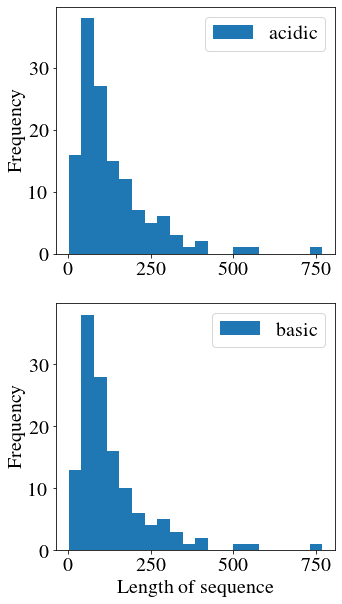

Summary statistics for: IDR_Sequences_Excluded.csv
-----------------------
1. Number of sequences: 200
2. Number of sequences with at least one block of ...
   acidic: 78
   basic: 91
3. Length distributions for sequences containing at least one block of ...


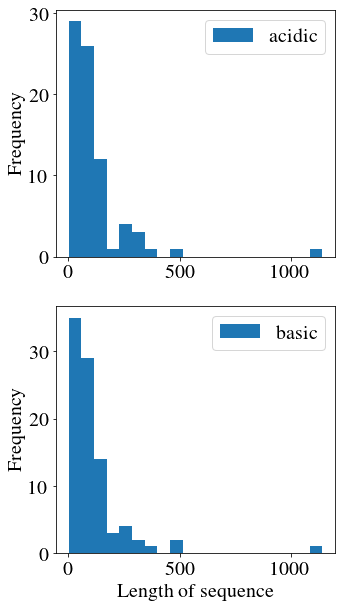

In [238]:
file_list = {'Partitioned': 'IDR_Sequences_Partitioned.csv', 
             'Excluded': 'IDR_Sequences_Excluded.csv'}
categories = ['acidic', 'basic']
statistics = {}

for keys, file in file_list.items():
    statistics[keys] = compute_statistics_from_file(analysis=analysis, filename=file, categories=categories)

# Print out results from analysis:
for keys, file in file_list.items():
    print('Summary statistics for: ' + file)
    print('-----------------------')
    print('1. Number of sequences: ' + str(statistics[keys]['Total number of sequences']))
    print('2. Number of sequences with at least one block of ...')
    fig,axs = plt.subplots(len(categories),1, figsize=(5, 5*len(categories)))
    for i in range(len(categories)):
        print('   ' + categories[i] + ': ' 
              + str(statistics[keys]['Total number of sequences with at least one block'][categories[i]]))
        freq_dist = axs[i].hist(statistics[keys]['Lengths of sequences with at least one block'][categories[i]], 
                             range=(1, 
                                    np.max(statistics[keys]['Lengths of sequences with at least one block'][categories[i]])), 
                             bins=20, label=categories[i])
        axs[i].set_ylabel('Frequency')
        axs[i].legend()
    axs[i].set_xlabel('Length of sequence')
    print('3. Length distributions for sequences containing at least one block of ...')
    plt.show()
    plt.close()

### Distribution of distances between pairs of blocks that contain residues from a pair of categories

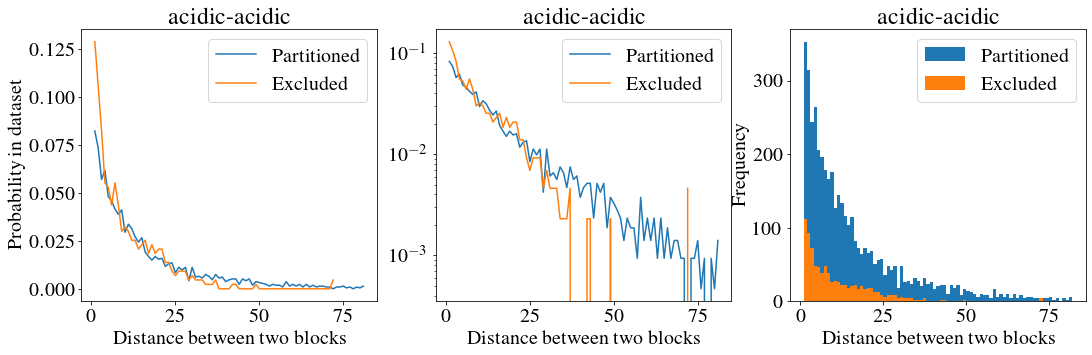

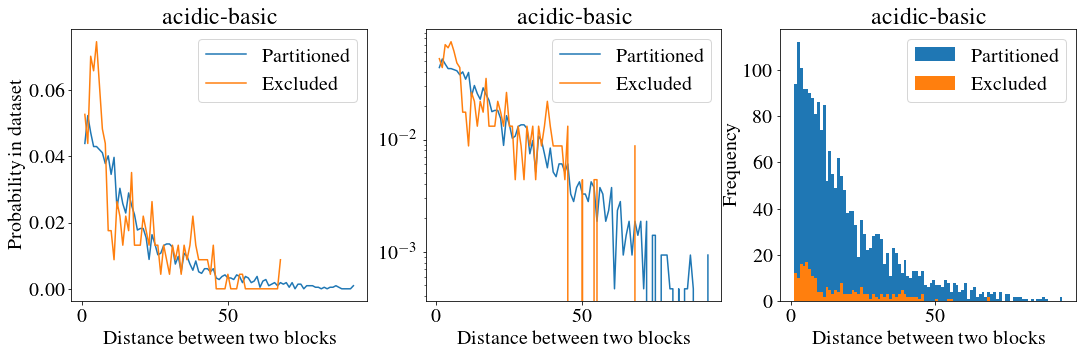

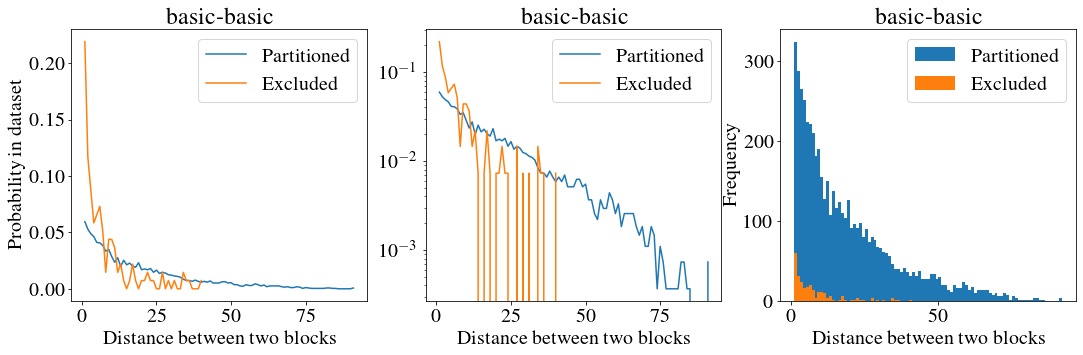

In [240]:
file_list = {'Partitioned': 'IDR_Sequences_Partitioned.csv', 
             'Excluded': 'IDR_Sequences_Excluded.csv'}
categories = ['acidic', 'basic']
statistics = {}

for keys, file in file_list.items():
    statistics[keys] = compute_statistics_from_file(analysis=analysis, filename=file, categories=categories)

for i in range(len(categories)):
    for j in range(i, len(categories)):
        number_of_files = len(file_list.keys())
        fig,axs = plt.subplots(1,3,figsize=(18,5))
        for file_key, file in file_list.items():
            category_key = categories[i] + '_' + categories[j]
            distance_list = statistics[file_key]['Distances between pairs of blocks'][category_key]
            freq_dist = axs[2].hist(distance_list, range=(1, np.max(distance_list)), bins=int(np.max(distance_list)-1), 
                                    label=file_key)
            counts, distances = freq_dist[0], freq_dist[1]
            probability = np.array(counts)/np.sum(counts)
            axs[0].plot(distances[:-1], probability, label=file_key)
            axs[1].semilogy(distances[:-1], probability, label=file_key)
        axs[0].set_xlabel('Distance between two blocks')
        axs[0].set_ylabel('Probability in dataset')
        axs[0].legend()
        axs[0].set_title(categories[i] + '-' + categories[j])
        axs[1].set_xlabel('Distance between two blocks')
        axs[1].legend()
        axs[1].set_title(categories[i] + '-' + categories[j])
        axs[2].set_xlabel('Distance between two blocks')
        axs[2].set_ylabel('Frequency')
        axs[2].legend()
        axs[2].set_title(categories[i] + '-' + categories[j])